In [ ]:
import requests
import pandas as pd
import time
import os

csv_path = "../data/raw_reviews.csv"


def scrape_digikala_reviews(product_id, max_pages=50):
    reviews_data = []
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    
    for page in range(1, max_pages+1):
        url = f"https://api.digikala.com/v1/product/{product_id}/comments/?page={page}&mode=newest"

        response = requests.get(url, headers=headers)
        
        if response.status_code != 200:
            print(f"Failed to get page {page}, status: {response.status_code}")
            break
        
        data = response.json()
        comments = data.get("data", {}).get("comments", [])
        
        if not comments:
            print(f"No more comments found at page {page}. Stopping.")
            break
        
        for c in comments:
            review_text = c.get("body", "").strip()
            rating = c.get("rate")
            if isinstance(rating, dict):
                rating = rating.get("rate")
            review_date = c.get("created_at", None)
            
            reviews_data.append({
                "review": review_text,
                "rating": rating,
                "date": review_date
            })

        
        time.sleep(1)  # avoid hitting server too fast
    
    return pd.DataFrame(reviews_data)

if os.path.exists(csv_path):
    os.remove(csv_path)
    print("Old raw_reviews.csv removed.")


df_reviews = scrape_digikala_reviews(product_id=19321474, max_pages=3)  
df_reviews.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"✅ Saved {len(df_reviews)} reviews to raw_reviews.csv")


Old raw_reviews.csv removed.
✅ Saved 60 reviews to raw_reviews.csv


In [ ]:
import pandas as pd
import re
import os

csv_path = "../data/cleaned_reviews.csv"
df = pd.read_csv("../data/raw_reviews.csv")
df.dropna(inplace=True)

if os.path.exists(csv_path):
    os.remove(csv_path)
    print("Old cleaned_reviews.csv removed.")

stopwords = set([
    'و', 'در', 'که', 'با', 'از', 'به', 'این', 'آن', 'را', 'برای', 
    'شد', 'می', 'تا', 'یک', 'بر', 'هم', 'ان', 'های', 'کن', 'کرد','است',
    '.','!','؟','؛','،'
    
])

def clean_text(text):

    text = re.sub(r'[^\u0600-\u06FF\s]', '', text) #english words
    text = re.sub(r'\d+', '', text)#numbers
    text = re.sub(r'\s+', ' ', text).strip()#empty spaces
    
    words = text.split()
    words = [w for w in words if w not in stopwords]
    
    return ' '.join(words)

df["cleaned_text"] = df["review"].apply(clean_text)

# labling sentiments 1 or 0
def label_sentiment(star):
    if star >= 4:
        return 1
    elif star <= 2:
        return 0
    else:
        return None

df["label"] = df["rating"].apply(label_sentiment)
df.dropna(inplace=True)
    
df.to_csv(csv_path, index=False)
print(f"✅ Saved cleaned_reviews.csv")


Old cleaned_reviews.csv removed.
✅ Saved cleaned_reviews.csv


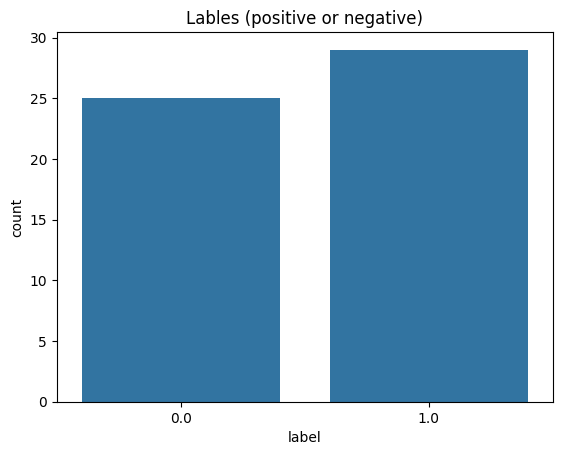

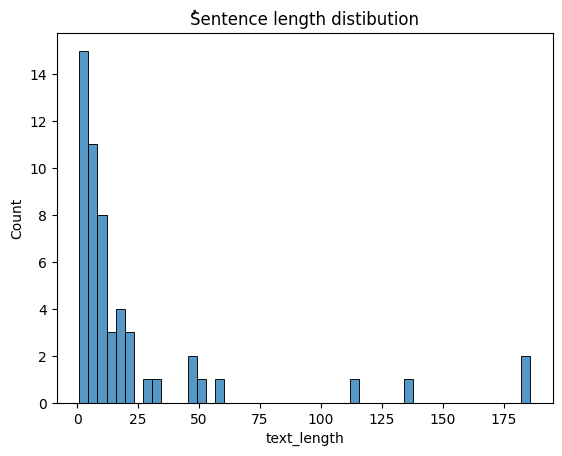

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


sns.countplot(x='label', data=df)
plt.title("Lables (positive or negative)")
plt.show()

df['text_length'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_length'], bins=50)
plt.title("ُSentence length distibution")
plt.show()

# word cloud  (not working for persion websites)
# positive_text = " ".join(df[df['label']==1]['cleaned_text'])
# negative_text = " ".join(df[df['label']==0]['cleaned_text'])

# wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
# wordcloud_neg = WordCloud(width=800, height=400, background_color="black").generate(negative_text)

# plt.imshow(wordcloud_pos); plt.axis("off"); plt.title("frequent positive words"); plt.show()
# plt.imshow(wordcloud_neg); plt.axis("off"); plt.title("frequent negative words"); plt.show()




In [62]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# CountVectorizer
count_vect = CountVectorizer(max_features=2000, ngram_range=(1,2))
X_count = count_vect.fit_transform(df['cleaned_text'])

# TF-IDF 
tfidf_vect = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
X_tfidf = tfidf_vect.fit_transform(df['cleaned_text'])

# Choose TF-IDF
X = X_tfidf 

y = df['label']

print("ابعاد ماتریس ویژگی‌ها (X):", X.shape)
print("تعداد برچسب‌ها (y):", y.shape)


ابعاد ماتریس ویژگی‌ها (X): (54, 1741)
تعداد برچسب‌ها (y): (54,)


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# data split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Logistic Regression Accuracy: 0.18181818181818182
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.18      1.00      0.31         2

    accuracy                           0.18        11
   macro avg       0.09      0.50      0.15        11
weighted avg       0.03      0.18      0.06        11

Naive Bayes Accuracy: 0.18181818181818182
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.18      1.00      0.31         2

    accuracy                           0.18        11
   macro avg       0.09      0.50      0.15        11
weighted avg       0.03      0.18      0.06        11



c:\Users\KAi2000\Documents\code\python\project_ai\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KAi2000\Documents\code\python\project_ai\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KAi2000\Documents\code\python\project_ai\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag